# Прототип системы прогнозирования спроса для сети магазинов одежды.

In [116]:
import pandas as pd
import matplotlib.pyplot as plt

## Чтение и анализ исходных данных

In [117]:
stock = pd.read_csv('data/Ostatok.txt', delimiter='\t')
sales = pd.read_csv('data/Sales.txt', delimiter='\t')

In [118]:
stock.info()
print('------------------------------------------------')
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6542793 entries, 0 to 6542792
Data columns (total 5 columns):
 #   Column                Dtype 
---  ------                ----- 
 0   Дата                  object
 1   КодМагазин            int64 
 2   КодНоменклатура       int64 
 3   ОстатокНаКонецДня     int64 
 4   НоменклатурнаяГруппа  object
dtypes: int64(3), object(2)
memory usage: 249.6+ MB
------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20880 entries, 0 to 20879
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Дата                  20880 non-null  object
 1   КодМагазин            20880 non-null  int64 
 2   КодНоменклатура       20880 non-null  int64 
 3   Количество            20880 non-null  object
 4   НоменклатурнаяГруппа  20880 non-null  object
dtypes: int64(2), object(3)
memory usage: 815.8+ KB


Типы данных неподходящие для вычислений, необходимо их сменить.


### Анализ числовых признаков

Количество в продажах не определяется как число, посмотрим, какие в этом столбце значения.

In [119]:
sales['Количество'].value_counts()

1     19860
2       548
-1      322
?        80
3        57
4         9
-2        4
Name: Количество, dtype: int64

Замена "?" на моду "1"

In [120]:
sales['Количество'] = sales['Количество'].replace('?', '1').astype('float64')


### Настройка типов данных

In [121]:
# Настройка типов для остатков
stock['Дата'] = pd.to_datetime(stock['Дата'], dayfirst=True) # для работы с датами и создания новых признаков
stock[['КодМагазин', 'КодНоменклатура', 'НоменклатурнаяГруппа']] = stock[['КодМагазин', 'КодНоменклатура', 'НоменклатурнаяГруппа']].astype('category')

# Настройка типов для продаж
sales['Дата'] = pd.to_datetime(sales['Дата'], dayfirst=True) # для работы с датами и создания новых признаков
sales[['КодМагазин', 'КодНоменклатура', 'НоменклатурнаяГруппа']] = sales[['КодМагазин', 'КодНоменклатура', 'НоменклатурнаяГруппа']].astype('category')

### Визуализация количественных признаков

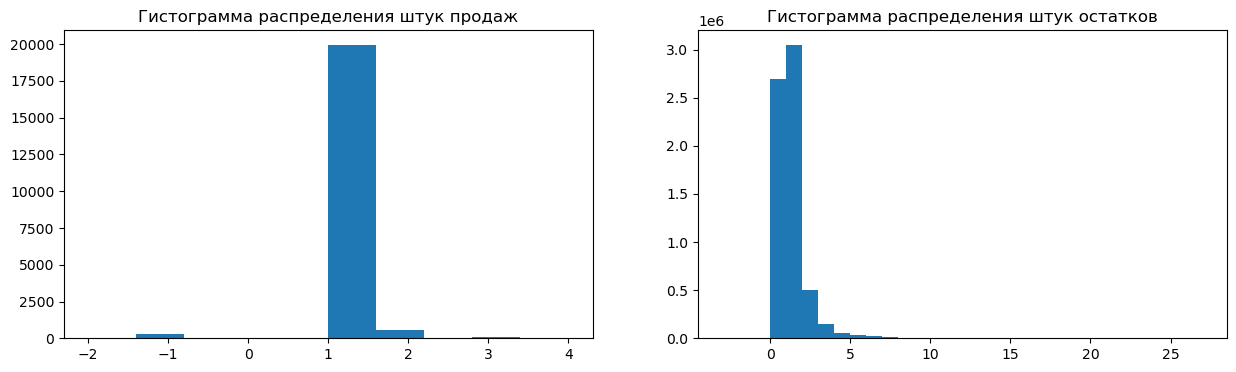

In [123]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))

#гистограмма продаж
axes[0].hist(x=sales['Количество'],
             label=['Количество'])
axes[0].set_title('Гистограмма распределения штук продаж');

#гистограмма остатков
axes[1].hist(x=stock['ОстатокНаКонецДня'],
             label=['ОстатокНаКонецДня'],
             bins=30)
axes[1].set_title('Гистограмма распределения штук остатков');

С остатками есть странные момент - это отрицательные остатки, чего физически быть не может (технически возможно из-за особенностей учета). Поэтому надо выяснять у заказчика, отрицательные остатки это "БАГ или фича". Посмотрим как распределены данные.
В качестве отрицательных продаж могут быть возвраты, поэтому отрицательные продажи оставляем.

### Структура таблиц

In [124]:
display(stock.head(2))
display(sales.head(2))

,Дата,КодМагазин,КодНоменклатура,ОстатокНаКонецДня,НоменклатурнаяГруппа
0,2019-01-29,83,48842,2,Сорочка для мальчика длинный рукав
1,2019-01-29,83,48842,1,Сорочка для мальчика длинный рукав


,Дата,КодМагазин,КодНоменклатура,Количество,НоменклатурнаяГруппа
0,2020-09-02,83,2234,1.0,Брюки для мальчика шк.форма
1,2020-09-04,83,2234,-1.0,Брюки для мальчика шк.форма


In [125]:
# Посмотрим на количество отрицательных значений.
sub_zero = stock[stock['ОстатокНаКонецДня']<0]['ОстатокНаКонецДня'].count()
доля_отрицательных = sub_zero/stock['ОстатокНаКонецДня'].count()*100
print(f' Всего отрицательных случаев - {sub_zero} \n Доля отрицательных случаев - {"%.4f%%" % доля_отрицательных}' )

 Всего отрицательных случаев - 3195 
 Доля отрицательных случаев - 0.0488%


### Описательная статистика остальных признаков

In [126]:
print('-------------------------Остатки на конец дня-------------------------------------')
display(stock.describe(include=['category']))
print('-------------------------Продажи---------------------------------------------------')
display(sales.describe(include=['category']))

-------------------------Остатки на конец дня-------------------------------------


,КодМагазин,КодНоменклатура,НоменклатурнаяГруппа
count,6542793,6542793,6542793
unique,5,349,3
top,83,2227,Брюки для мальчика шк.форма
freq,2088833,379473,2888558


-------------------------Продажи---------------------------------------------------


,КодМагазин,КодНоменклатура,НоменклатурнаяГруппа
count,20880,20880,20880
unique,5,343,3
top,83,107883,Сорочка для мальчика длинный рукав
freq,5325,622,10052


По названию номенклатурных групп делаю вывод что сеть специализируется на детской школьной одежде. А значит, буду ожидать сезонных всплесков продаж в августе.

### За какой интервал есть данные

In [127]:
min_date_stock = stock['Дата'].min().strftime("%d.%m.%Y")
max_date_stock = stock['Дата'].max().strftime("%d.%m.%Y")
print(f"Интервал дат остатков с {min_date_stock} по {max_date_stock}")

min_date_sales = sales['Дата'].min().strftime("%d.%m.%Y")
max_date_sales = sales['Дата'].max().strftime("%d.%m.%Y")
print(f"Интервал дат продаж с {min_date_sales} по {max_date_sales}")

Интервал дат остатков с 01.01.2019 по 31.12.2021
Интервал дат продаж с 02.01.2019 по 31.12.2021


## Создание признаков "Месяц" и "Год"

In [128]:
sales['Месяц'] = sales['Дата'].dt.month.astype('category')
sales['Год'] = sales['Дата'].dt.year.astype('category')

In [129]:
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20880 entries, 0 to 20879
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Дата                  20880 non-null  datetime64[ns]
 1   КодМагазин            20880 non-null  category      
 2   КодНоменклатура       20880 non-null  category      
 3   Количество            20880 non-null  float64       
 4   НоменклатурнаяГруппа  20880 non-null  category      
 5   Месяц                 20880 non-null  category      
 6   Год                   20880 non-null  category      
dtypes: category(5), datetime64[ns](1), float64(1)
memory usage: 460.4 KB


Все нужные типы данных применены.

## Группировка данных

In [130]:
# По коду номенклатуры
sales_pivot_sku = sales.pivot_table(
    values='Количество',
    index=['КодНоменклатура', 'КодМагазин', 'Месяц'],
    columns='Год',
    aggfunc='sum',
    fill_value=0
).round()

# По номенклатурной группе
sales_pivot_group = sales.pivot_table(
    values='Количество',
    index=['НоменклатурнаяГруппа', 'КодМагазин', 'Месяц'],
    columns='Год',
    aggfunc='sum',
    fill_value=0
).round()

### Структура полученных таблиц

In [131]:
display(sales_pivot_sku.head(3))
display(sales_pivot_group.head(3))

Год                               2019  2020  2021
КодНоменклатура КодМагазин Месяц                  
2221            83         1         5     5     0
                           2         8     2     1
                           3         4     0     1

Год                                           2019  2020  2021
НоменклатурнаяГруппа        КодМагазин Месяц                  
Брюки для мальчика шк.форма 83         1        25    25    25
                                       2        22    16    15
                                       3        19    11    13

## Функция прогноза

In [132]:

def get_predict(df, w1 = 0.6, w2 = 0.25, w3 = 0.15):
    y = list(df.columns)[-1]+1 # для прогнозирования выбирается следующий год
    df[y] = round(df[y-1]*w1 + df[y-2]*w2 + df[y-3]*w3, 0)

Алгоритм работы функции прогнозирования.
На вход подается таблица с продажами, и веса для предыдущих трех лет. Если веса не задавать, то будут использоваться значения, прописанные в функции как умолчания (предыдущий год - 0.6, минус 2 года - 0.25, минус 3 года - 1.5), где наибольшее влияние на прогноз оказывает последний год, для сохранения тренда. Далее значения предыдущих лет перемножаются на свои веса и складываются, формируя прогнозное значение на следующий год. Прогноз на второй год работает аналогичным образом, учитывая значения спрогнозированного года.

### Выполнение функции прогнозирования

In [133]:
n = 2 # На сколько лет рассчитать прогноз

for i in range(n):
    get_predict(sales_pivot_sku)
    print(f'Прогноз по номенклатуре на +{i+1} год рассчитан.')
    get_predict(sales_pivot_group)
    print(f'Прогноз по номенклатурным группам на +{i+1} год рассчитан.')

Прогноз по номенклатуре на +1 год рассчитан.
Прогноз по номенклатурным группам на +1 год рассчитан.
Прогноз по номенклатуре на +2 год рассчитан.
Прогноз по номенклатурным группам на +2 год рассчитан.


In [134]:
# Сбрасываю индексы
sales_pivot_group = sales_pivot_group.reset_index()
sales_pivot_sku = sales_pivot_sku.reset_index()

## Преобразование таблиц к итоговому для ТЗ виду

In [135]:
sales_sku_new = pd.melt(sales_pivot_sku, id_vars=['КодНоменклатура', 'КодМагазин', 'Месяц'],
                 var_name='Год продажи', value_name='Продажи')

sales_group_new = pd.melt(sales_pivot_group, id_vars=['НоменклатурнаяГруппа', 'КодМагазин', 'Месяц'],
                 var_name='Год продажи', value_name='Продажи')

In [136]:
# Добавляю столбец с датой на начало месяца
sales_sku_new['Дата'] = sales_sku_new.apply(lambda row: f"1.{row['Месяц']}.{row['Год продажи']}", axis=1)
sales_group_new['Дата'] = sales_group_new.apply(lambda row: f"1.{row['Месяц']}.{row['Год продажи']}", axis=1)

# Удаляю лишние столбцы
sales_sku_new.drop(['Год продажи', 'Месяц'], axis=1, inplace=True)
sales_group_new.drop(['Год продажи', 'Месяц'], axis=1, inplace=True)

# Переупорядочивание
sales_sku_new = sales_sku_new[['Дата', 'КодМагазин', 'КодНоменклатура', 'Продажи']]
sales_group_new = sales_group_new[['Дата', 'КодМагазин', 'НоменклатурнаяГруппа', 'Продажи']]

In [137]:
display(sales_sku_new.head(2))
display(sales_group_new.head(2))

,Дата,КодМагазин,КодНоменклатура,Продажи
0,1.1.2019,83,2221,5.0
1,1.2.2019,83,2221,8.0


,Дата,КодМагазин,НоменклатурнаяГруппа,Продажи
0,1.1.2019,83,Брюки для мальчика шк.форма,25.0
1,1.2.2019,83,Брюки для мальчика шк.форма,22.0


## Экспорт результатов

In [138]:
sales_group_new.to_excel('data/ПрознозПоГруппам.xlsx', index=False)
sales_sku_new.to_excel('data/ПрогнозПоНоменклатуре.xlsx', index=False)